In [55]:
import numpy as np
from scipy.ndimage import median_filter
from scipy.stats import rankdata
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from scipy.ndimage import median_filter

### Ideia

Fazer o denoising por "patches acumulados".

patch = pedaço de um frame.

Os patches são acumulados por similaridade (8x8 => 64, via flatten).

Eles podem vir de diferentes frames do vídeo, o que contempla a ideia de aproveitar o aspecto temporal do vídeo, ao menos parcialmente.

In [56]:
import numpy as np

def patchmatcher(patchArr, refj, refk, frameno):
    # Input:
    #   patchArr : vectorized patches of the video, (64, height // 4 - 1, width // 4 - 1, nframes) (uint8)
    #   refj     : j value of reference patch
    #   refk     : k value of reference patch
    #   frameno  : frame number of reference patch
    # Output:
    #   indices : indices of matching patches, (3, nframes*5) (uint8)
    
    nframes, dim1, dim2 = patchArr.shape[3], patchArr.shape[1], patchArr.shape[2]

    # Cast to float for distance calculation
    patch = patchArr.astype(np.float64)

    # Generating l1 norm distance matrix
    ref_patch = patch[:, refj, refk, frameno]  # Reference patch
    M_ = np.sum(np.abs(patch - ref_patch[:, np.newaxis, np.newaxis, np.newaxis]), axis=0)  # Shape: (dim1, dim2, nframes)
    
    # Reshape M_ to find distances across frames
    M = M_.reshape(dim1 * dim2, nframes)

    # Finding 5 min distance patches for each frame
    indices_flat = np.argsort(M, axis=0)[:5]  # Get indices of 5 closest patches for each frame

    # Getting j, k values of matching patches
    row, col = np.unravel_index(indices_flat, (dim1, dim2))

    # Reshaping to form indices
    indices = np.array([row.flatten(), col.flatten(), np.repeat(np.arange(nframes), 5)])

    # Casting to uint8 as they are further used as index to get the patches
    return indices.astype(np.uint8)

In [57]:
def svti(P, Omega, tau, kmax, tol, sec_missing):
    # Input:
    #   P           : noisy patch matrix with missing pixels, (64, n2) (double)
    #   Omega       : boolean matrix of known pixels, (64, n2) (bool)
    #   tau         : step size
    #   kmax        : maximum iterations
    #   tol         : tolerance
    #   sec_missing : whether second subset of missing pixels to be taken
    # Output:
    #   Q    : denoised patch matrix, (64, n2) (uint8)
    #   iter : iterations required
    # Brief:
    #   Apply SVT on the patch matrix to remove noise and fill in missing pixels

    n2 = P.shape[1]

    # Finding sigma and mean for each row
    sigma_bar = np.zeros(64, dtype=np.float64)
    for i in range(64):
        Pi = P[i, :]
        sigma_bar[i] = np.std(Pi[Omega[i, :]])

        # Second subset of missing pixels
        if sec_missing:
            mu_bar = np.mean(Pi[Omega[i, :]])
            Omega[i, :] = Omega[i, :] & (Pi <= mu_bar + 2 * sigma_bar[i]) & (Pi >= mu_bar - 2 * sigma_bar[i])

    # Calculating mu
    sigma_hat = np.mean(sigma_bar)
    p = np.sum(Omega) / Omega.size
    mu = (8 + np.sqrt(n2)) * np.sqrt(p) * sigma_hat
    lambda_ = tau * mu

    # Initializing
    Q = np.zeros_like(P, dtype=np.float64)

    # Iteration
    for k in range(kmax):
        # Projection Operator
        P_ = Q - P
        P_[~Omega] = 0

        # SVD on residual R
        R = Q - tau * P_
        U, S, Vt = np.linalg.svd(R, full_matrices=False)  # 'econ' in MATLAB corresponds to full_matrices=False in NumPy

        # Soft thresholding of singular values by lambda
        Q_new = U @ np.diag(np.maximum(S - lambda_, 0)) @ Vt

        # Check convergence condition
        if np.linalg.norm(Q_new - Q, 'fro') <= tol:
            Q = Q_new
            break

        # Save and continue
        Q = Q_new

    iter_count = k + 1  # Add 1 because k is zero-based in Python
    return Q.astype(np.uint8), iter_count

In [58]:
def lrmc(noisy, frameno, tau, kmax, tol, variant):
    # Input:
    #   noisy   : noisy video, (nframes, height, width) (uint8)
    #   frameno : frame number to be denoised
    #   tau     : step size
    #   kmax    : maximum iterations
    #   tol     : tolerance
    #   variant : two binary digits representing specific options
    
    # Output:
    #   recon    : denoised video, (nframes, height, width) (uint8)
    #   filtered : video after applying adaptive median filter, (nframes, height, width) (uint8)
    
    # Setting options based on variant
    sec_missing, replace = {
        '00': (False, False),
        '01': (False, True),
        '10': (True, False),
        '11': (True, True)
    }.get(variant, (False, True))

    nframes, height, width = noisy.shape

    # Applying adaptive median filter
    filtered = np.zeros_like(noisy, dtype=np.uint8)
    for i in tqdm(range(nframes)):
        filtered[i] = median_filter(noisy[i], size=11)

    # Identifying missing pixels
    missing = (filtered != noisy)

    # Generating patch and missing arrays
    patchArr = np.zeros((64, (height // 4 - 1), (width // 4 - 1), nframes), dtype=np.uint8)
    missingArr = np.zeros_like(patchArr, dtype=bool)

    for i in tqdm(range(nframes)):
        for j in range(height // 4 - 1):
            for k in range(width // 4 - 1):
                patchArr[:, j, k, i] = filtered[i, 4 * j:4 * (j + 2), 4 * k:4 * (k + 2)].reshape(64)
                missingArr[:, j, k, i] = missing[i, 4 * j:4 * (j + 2), 4 * k:4 * (k + 2)].reshape(64)

    # Iteratively denoising each patch
    denoisedpatchArr = np.zeros_like(patchArr, dtype=np.float64)
    for refj in tqdm(range(height // 4 - 1)):
        for refk in range(width // 4 - 1):
            # Finding matching patches
            indices = patchmatcher(patchArr, refj, refk, frameno)

            # Creating patch matrix and Omega
            patchMat = np.zeros((64, indices.shape[1]), dtype=np.uint8)
            patchOmega = np.zeros((64, indices.shape[1]), dtype=bool)
            for i in range(indices.shape[1]):
                patchMat[:, i] = patchArr[:, indices[0, i], indices[1, i], indices[2, i]]
                patchOmega[:, i] = ~missingArr[:, indices[0, i], indices[1, i], indices[2, i]]

            # Running SVT algorithm
            denoisedpatchMat, _ = svti(patchMat.astype(float), patchOmega, tau, kmax, tol, sec_missing)

            # Finding and updating reference patch
            selfind = next(
                (si for si in range(5 * (frameno - 1), 5 * frameno)
                 if np.array_equal(indices[:, si], [refj, refk, frameno - 1])),
                None
            )
            if selfind is not None:
                if replace:
                    patchArr[:, refj, refk, frameno - 1] = denoisedpatchMat[:, selfind]
                denoisedpatchArr[:, refj, refk, frameno - 1] = denoisedpatchMat[:, selfind]

    # Averaged reconstruction from denoised patch array
    recon = np.zeros_like(filtered, dtype=np.float64)
    weight = np.zeros_like(recon)

    for i in tqdm(range(nframes)):
        for j in range(height // 4 - 1):
            for k in range(width // 4 - 1):
                patch = denoisedpatchArr[:, j, k, i].reshape(8, 8)
                recon[i, 4 * j:4 * (j + 2), 4 * k:4 * (k + 2)] += patch
                weight[i, 4 * j:4 * (j + 2), 4 * k:4 * (k + 2)] += 1

    # Normalizing by weights and converting to uint8
    recon = np.divide(recon, weight, out=np.zeros_like(recon), where=weight != 0)
    return recon.astype(np.uint8), filtered

In [59]:
def noisemodel(frames, sigma, k, s):
    """
    Add Gaussian, Poisson, and Impulsive noise to the video.

    Parameters:
    frames (np.ndarray): Original video of shape (dim1, dim2, nframes) (uint8).
    sigma (float): Standard deviation of Gaussian noise.
    k (float): Variance factor of Poisson noise.
    s (float): Percentage of impulsive noise.

    Returns:
    np.ndarray: Noisy video of shape (dim1, dim2, nframes) (uint8).
    """
    dim1, dim2, nframes = frames.shape

    # Convert frames to float for noise addition
    noisy = frames.astype(np.float64)

    # Poisson Noise
    np_noise = np.random.poisson(k * noisy) - k * noisy

    # Gaussian Noise
    ng = sigma * np.random.randn(dim1, dim2, nframes)

    # Combine noises
    noisy += np_noise + ng

    # Impulsive noise
    X = np.random.rand(dim1, dim2, nframes)
    noisy[X < s / 200] = 0  # Set impulsive noise to 0
    noisy[X > 1 - s / 200] = 255  # Set impulsive noise to 255

    # Cast back to uint8
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)

    return noisy

In [60]:
def read_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    # List to store frames
    frames = []
    
    # Read frames from the video
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Exit if there are no more frames
        
        # Convert frame to grayscale (if needed)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Convert to uint8
        gray_frame = gray_frame.astype(np.uint8)
        
        # Append the frame to the list
        frames.append(gray_frame)

    # Release the video capture object
    cap.release()
    
    # Convert list of frames to a numpy array
    video_data = np.array(frames)
    return video_data

In [61]:
data = read_video('../data/carphone_qcif.y4m')
data.shape

(382, 144, 176)

In [62]:
data[0].shape

(144, 176)

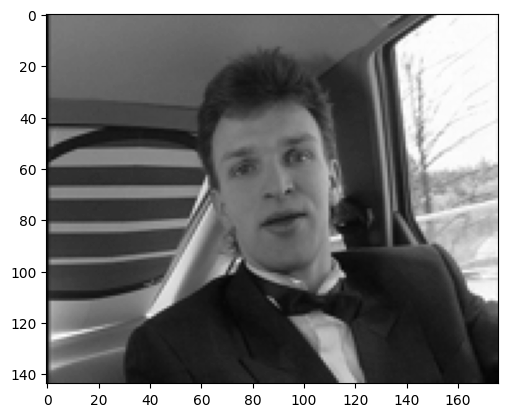

In [63]:
plt.imshow(data[0], cmap='gray')

382 quadros de dimensão 176x144.

In [64]:
nnn = noisemodel(data, 10, 0.01, 5)

In [65]:
# play the video
'''fig, ax = plt.subplots()
img_display = ax.imshow(noisy[0], cmap='gray')
ax.axis('off')  # Hide the axes

def update(frame):
    img_display.set_array(noisy[frame])
    return img_display,

ani = animation.FuncAnimation(fig, update, frames=range(noisy.shape[0]), interval=100)

# save to compressed format
ani.save('../noisy.mp4', writer='ffmpeg', fps=30)'''

"fig, ax = plt.subplots()\nimg_display = ax.imshow(noisy[0], cmap='gray')\nax.axis('off')  # Hide the axes\n\ndef update(frame):\n    img_display.set_array(noisy[frame])\n    return img_display,\n\nani = animation.FuncAnimation(fig, update, frames=range(noisy.shape[0]), interval=100)\n\n# save to compressed format\nani.save('../noisy.mp4', writer='ffmpeg', fps=30)"

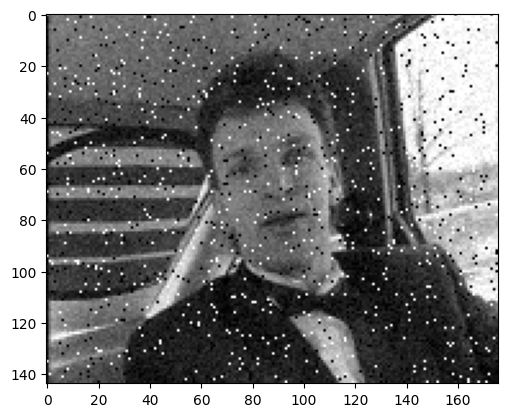

In [66]:
plt.imshow(nnn[0], cmap='gray')

In [67]:
nnn.shape

(382, 144, 176)

In [68]:
frameno = 10
tau = 1.5
kmax = 30
tol = 1e-5
variant = '01'

recon, filtered = lrmc(nnn, frameno, tau, kmax, tol, variant)
np.save('filtered2.npy', filtered)
np.save('recon2.npy', recon)

100%|██████████| 382/382 [00:02<00:00, 156.89it/s]


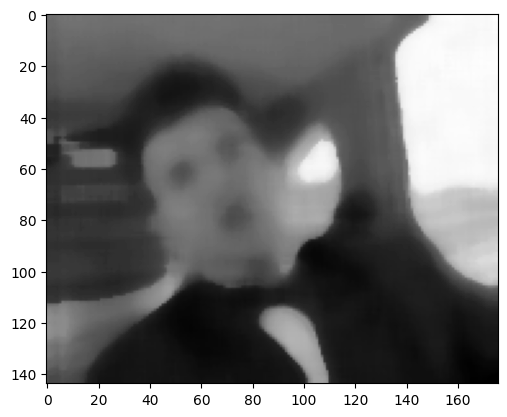

In [75]:
plt.imshow(filtered[100], cmap='gray')

In [72]:
recon.shape

(382, 144, 176)

In [73]:
recon[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)